## All about Non-Collision Backgrounds

<CENTER><img src="https://github.com/zlmarshall/notebooks-collection-opendata/blob/DQ_and_NCB/images/ATLASOD.gif?raw=1" style="width:50%"></CENTER>

This notebook uses [ATLAS Open Data](http://opendata.atlas.cern) [2025 beta release](https://opendata.atlas.cern/docs/data/for_education/13TeV25_details) to teach you a bit about the concept "Non-Collision Backgrounds". It is intended for an education audience and is written to be accessible to a wide range of students.

### What are Non-collision Backgrounds?

ATLAS is built to study collisions between protons (and between heavy ions) that happen right in the center of the detector. It does that by carefully measuring all the particles that come flying out of each collision, like a camera. That also leaves it sensitive to a variety of other things that can happen, which are generally described as "Non-collision backgrounds". The most common examples of non-collision backgrounds are:

* [Cosmic rays](https://en.wikipedia.org/wiki/Cosmic_ray). These are usually muons that come from the upper atmosphere and fly through the detector (they also fly through *you*, as you're sitting there, all the time). They look just like muons that come from collisions, except they usually come at funny angles (because they aren't passing straight through the center of the detector), and they often come at strange times (they can arrive when the collider has no protons in it! They can also come *between* bunches of protons).

* Detector noise. Just like static on a radio, the electronics in our detector sometimes have noise. Usually these look different from the signals we are looking for (just like you can tell the difference between static on your radio and music). Sometimes the static is so loud we can't hear the music any more, and then the data have to be discarded.

* Beam halo. As the protons fly around the ring of the LHC in bunches, there are [collimators](https://en.wikipedia.org/wiki/Collimator) that block any protons that get too far out of a normal orbit. Those protons don't just stop; they can produce sprays of particles that run parallel to the original proton beam and sometimes find their way into the detector. They usually come at funny angles, and move across the detector from one side to the other, rather than coming out of the center like particles from a collision.

* Beam gas. The proton bunches go around the LHC in a beam pipe that is *nearly* a vacuum, but it's not perfect. Sometimes there can be collisions between protons from the beam and stray atoms of gas in the beam pipe. They tend to be very asymmetric-looking (because the gas is drifting slowly, and the beam is running full-speed into it), and they tend to be off-center (because the gas can be anywhere in the beam pipe, not only in the very center).

## Getting into the data

Now that we know the idea, we're going to get into using the ATLAS Open Data to look at non-collision backgrounds!

Because analyses do their best to remove these backgrounds from the data, we don't try to model them in our [detector simulation](https://opendata.atlas.cern/docs/documentation/monte_carlo/introduction_MC). That means we are going to look only into the data for this analysis.

## ATLAS Open Data Initialisation

### First time package installation on your computer (not needed on mybinder)
This first cell installs the required python packages.
It only needs to be run the first time you open this notebook on your computer.
If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If this is opened on mybinder, you don't need to run this cell.

In [ ]:
import sys
import os.path
!pip install atlasopenmagic
from atlasopenmagic import install_from_environment
install_from_environment()

We're going to import a number of packages to help us:
* `numpy`: provides numerical calculations such as histogramming
* `matplotlib`: common tool for making plots, figures, images, visualisations
* `uproot`: processes `.root` files typically used in particle physics into data formats used in python
* `awkward`: introduces `awkward` arrays, a format that generalizes `numpy` to nested data with possibly variable length lists
* `vector`: to allow vectorized 4-momentum calculations

In case this fails the first time you run it, and you've just installed new packages, you might just need to restart the jupyter kernel and try again.

In [2]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import hist # for histogramming
# Import vector and set it up for use with awkward array
import vector
vector.register_awkward()

We will use the [atlasopenmagic](https://opendata.atlas.cern/docs/data/atlasopenmagic) to access the open data directly from the ATLAS OpenData Portal so no need to download any samples. First we need to set the right release.

In [ ]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

## Bad jets: a sign of non-collision backgrounds

The Monte Carlo simulation is free from non-collision backgrounds, so we will look directly at the detector data for examples.

In [4]:
# Build a list of the data samples to go over; we'll just get the locations of the files we need
data_samples = atom.get_urls('data', protocol='https')

One give-away that something has gone wrong in an event (that a non-collision background or some other data quality issue is present) is a large amount of missing transverse momentum. In the LHC, the proton beams collide head-on. Because of momentum conservation, if there are particles that fly out in one direction (up, for example), some particles have to fly out in the opposite direction (down, in that example). An imbalance in the momentum in the collision might be an indication of detector signals that aren't coming from a collision. Let's select events with no leptons (for the more advanced student: this will help remove Standard Model events that often have missing transverse momentum from neutrinos, like the decays of W bosons into a lepton and a neutrino), at least one jet above 150 GeV, and at least 100 GeV of missing transverse momentum.

In [5]:
# Define what variables are important to our analysis
# We want the number of leptons, number of jets, the transverse momenta and phi angles of the jets, and the amount of missing transverse momentum
variables = ['lep_n','jet_n','jet_pt','jet_phi','met']

Now we can run over all the data and see what events pass our selections

In [ ]:
# We'll use the hist package to define a histogram in advance
# We'll be filling it as we go along, so that we save minimal data in memory
phihist = hist.Hist(hist.axis.Regular(40, -np.pi, np.pi, label="Leading jet phi"))

# In case you'd like to run over a subset of the data, specify a number of events here
# -1 will not stop; any positive number will stop once the histogram has at least that
# many entries in it
stop_early = 10000

for afile in data_samples:
    # Tell the folks how we are doing
    print(f'Working on file {afile}')

    # Open the tree called "analysis" from our file - that's where the event data are
    tree = uproot.open({'simplecache::'+ afile:"analysis"})

    # Perform the cuts for each data entry in the tree
    # the data will be in the form of an awkward array because we are using the library 'ak' (for awkward)
    for n,data in enumerate(tree.iterate(variables, library="ak")):
        # Let's let folks know how things are going regularly, so they don't get worried
        if (n+1)%10==0:
            print(f'Working on data chunk {n+1}')

        # In this array programming setup, cuts are defined like boolean objects
        # They can be added together with &

        # Start with a cut: Require zero leptons in the event
        cut = (data['lep_n']==0)

        # Add a cut: Require at least one jet
        cut = cut & (data['jet_n']>0)

        # Add a cut: Require at least 100 GeV of MET
        cut = cut & (data['met']>100)

        # Add a cut: Require at least one jet with at least 150 GeV of pT
        cut = cut & (data['jet_pt']>150)

        # Plot the phi of the highest pT jet after the above cuts are applied
        # This is tricky syntax! We get the 'jet_phi' values from data;
        # We apply the cut, and we ask for the first element of the array
        # (because the jet variables are sorted by the pT of the jet, this
        # gives us the phi of the highest transverse momentum jet)
        # Then we flatten the data with awkward - that strips out all the
        # events that didn't pass our cuts, and gives us just a list of the
        # phi values for the jets. Finally, we fill the histogram with that
        # list of phi values
        phihist.fill( ak.flatten(data['jet_phi'][cut][:,:1]) )

        # If we were asked to stop early, stop now
        if stop_early>0 and phihist.sum()>stop_early:
            print(f'Stopping early after {phihist.sum()} entries in the histogram (requested at least {stop_early}).')
            break
    # Little trick to continue only if we didn't try to stop early
    else:
        continue
    break

We can now plot the data using Matplotlib. Most of the code here is for the aesthetics of the plot.

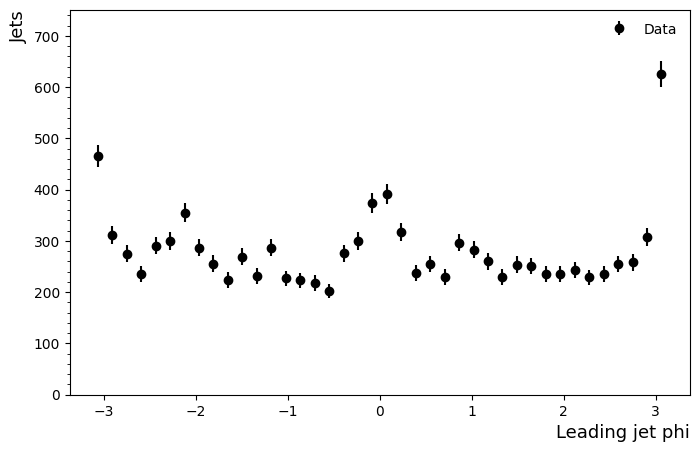

In [7]:
# We're going to make a plot with the matplotlib package
# It's quite powerful and has lots of nice features, but the syntax takes some getting used to

# Set up the figure and the axes on which we'll draw
fig, ax = plt.subplots(figsize=(8, 5))

# Convert from our hist histogram to a numpy array of values
y,bin_edges = phihist.to_numpy()
# Calculate errors
# The statistical uncertainty is just the square root of the number of counts
yerr = np.sqrt(y)
# Slightly awkward - convert from bin edges, which is what hist gives us, into bin centers, which is what matplotlib wants
x = [ (bin_edges[n]+bin_edges[n+1])/2. for n in range(len(bin_edges)-1) ]

# Now we can define the actual plot
ax.errorbar(x=x, y=y, yerr=yerr,
                    fmt='ko', # 'k' means black and 'o' is for circles
                    label='Data')

# x-axis label
ax.set_xlabel(r'Leading jet phi',
                    fontsize=13, x=1, horizontalalignment='right')

# write y-axis label for main axes
ax.set_ylabel('Jets',
                     fontsize=13, y=1, horizontalalignment='right')

# set y-axis limits for main axes
ax.set_ylim( bottom=0, top=np.amax(y)*1.2 )

# add minor ticks on y-axis for main axes
ax.yaxis.set_minor_locator( AutoMinorLocator() )

# draw the legend
ax.legend( frameon=False ); # no box around the legend

A great success! Now, what does the plot mean?

What we're showing here is the angle of the highest transverse momentum jet in the event. The detector is designed to be symmetrical, like a can. The proton collisions don't know which way is up. So, if there are no detector issues and no non-collision backgrounds, this should be a perfectly flat distribution. It's not!

There are some small bumps that you can see around -2.5 to -0.5, and 0.5 to 2.5. Those are generally because some parts of the detector had problems. In this case, they weren't severe enough problems that we removed the data, but if a particular data analysis is very sensitive, it might have to apply corrections to fix those issues.

You can see two *big* excesses at 0 and pi (the edges of the histogram). Those are because of non-collision backgrounds! The way the collimators are arranged, the shielding of the detector, and even the physical structures supporting it (which are often made of steel) block more of the non-collision background at some angles than at others, and those bumps show areas where there's additional background created that doesn't get blocked.

For some data analyses, this is very dangerous! For example, if someone is searching for new physics that leaves a signal in the detector like a high-momentum jet and missing transverse momentum (that's what dark matter would look like in our detector!), then they need to be able to cut down on the amount of non-collision background. We have various tricks to do that (some of which are called "jet cleaning", because they are built to identify jets that have particularly funny properties in the detector) that the most sensitive analyses have to carefully apply.

Feel free to play around with the jet transverse momentum and missing transverse momentum cuts to see how you can enhance the non-collision background in the plot. If you don't require any missing transverse momentum, the background is totally invisible!
<div class="alert alert-block alert-info">
We welcome your feedback on this notebook or any of our other materials! Please <a href="https://forms.gle/zKBqS1opAHHemv9U7">fill out this survey</a> to let us know how we're doing, and you can enter a raffle to win some <a href="https://atlas-secretariat.web.cern.ch/merchandise">ATLAS merchandise</a>!
</div>